# 🔄 Customer Churn Prediction Modeling
## Machine Learning for Churn Risk Assessment

This notebook develops predictive models to identify customers at risk of churning, enabling proactive retention strategies.

**Project:** Customer Insights Analytics  
**Author:** Aviwe Dlepu  
**Date:** July 2025

---

## 📚 1. Library Imports and Setup

In [1]:
# 📚 Standard Libraries
import os
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# 🤖 Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 🎯 Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# 📊 Model Evaluation
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, f1_score, accuracy_score, precision_score, recall_score
)

# 🎨 Visualization Libraries
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 🔧 Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 🔑 2. BigQuery Authentication and Setup

In [2]:
# 🔧 CORRECTED BIGQUERY SETUP FOR CHURN MODELING
from google.cloud import bigquery
import os
import pandas as pd
import numpy as np

# Set the path to your service account JSON key file
# IMPORTANT: Ensure this file is in your project root and excluded in .gitignore
key_path = "customerinsightsavy-083b71a1c086.json"

# Set the environment variable for authentication if not already set
if not os.getenv("GOOGLE_APPLICATION_CREDENTIALS"):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = key_path

# 🔧 CORRECTED: Initialize BigQuery client with proper configuration
try:
    client = bigquery.Client(project="customerinsightsavy")
    print("✅ BigQuery client initialized successfully")
    print(f"📊 Project ID: {client.project}")
except Exception as e:
    print(f"❌ Error initializing BigQuery client: {e}")
    print("🔧 Please ensure your service account JSON file is properly configured")

# 🔧 CORRECTED: Dataset configuration
PROJECT_ID = "customerinsightsavy"
DATASET_ID = "Ecommerce_Data"  # ← CORRECTED from ecommerce_data
DATASET_LOCATION = "US"

print(f"🔧 Using dataset: {PROJECT_ID}.{DATASET_ID}")
print(f"📍 Dataset location: {DATASET_LOCATION}")

# Reusable function to run queries with proper error handling
def run_query(query, job_config=None):
    """
    Execute a BigQuery SQL query and return results as a pandas DataFrame
    """
    try:
        # Configure query job
        if job_config is None:
            job_config = bigquery.QueryJobConfig()
        
        # Execute query
        query_job = client.query(query, job_config=job_config)
        
        # Get results
        results = query_job.result()
        df = results.to_dataframe()
        
        print(f"✅ Query executed successfully")
        print(f"📊 Returned {len(df):,} rows and {len(df.columns)} columns")
        
        return df
        
    except Exception as e:
        print(f"❌ Query execution failed: {e}")
        print(f"🔧 Please check your query syntax and dataset access permissions")
        return None

# Test the connection
test_query = f"""
SELECT COUNT(*) as table_count
FROM `{PROJECT_ID}.{DATASET_ID}.INFORMATION_SCHEMA.TABLES`
"""

try:
    test_result = run_query(test_query)
    if test_result is not None:
        print(f"🎉 Connection test successful! Found {test_result['table_count'].iloc[0]} tables in dataset")
    else:
        print("⚠️ Connection test failed")
except Exception as e:
    print(f"⚠️ Connection test error: {e}")

print("\n🔧 BigQuery setup completed!")


✅ BigQuery client initialized successfully
📊 Project ID: customerinsightsavy
🔧 Using dataset: customerinsightsavy.Ecommerce_Data
📍 Dataset location: US
✅ Query executed successfully
📊 Returned 1 rows and 1 columns
🎉 Connection test successful! Found 6 tables in dataset

🔧 BigQuery setup completed!


## 📊 3. Data Loading for Churn Modeling

In [7]:
# 🔧 CORRECTED CHURN MODELING DATA LOADING
# 🔧 CORRECTED CHURN MODELING DATA LOADING
print("🔄 Loading data for churn modeling...")

# 🔧 CORRECTED: Updated dataset names and improved query with TotalAmount formula
churn_modeling_query = f"""
WITH customer_features AS (
  SELECT 
    c.CustomerID,
    c.Age,
    c.Gender,
    c.City,
    c.Province,
    c.TotalSpend,
    c.NumberOfOrders,
    c.NumberOfReturnedOrders,
    c.NumberOfCanceledOrders,
    
    -- Target variable: Customer churn indicator
    CASE WHEN ch.CustomerID IS NOT NULL THEN 1 ELSE 0 END as Churned,
    
    -- Behavioral features
    CASE WHEN c.NumberOfOrders > 0 THEN c.TotalSpend / c.NumberOfOrders ELSE 0 END as AvgOrderValue,
    CASE WHEN c.NumberOfOrders > 0 THEN c.NumberOfReturnedOrders / c.NumberOfOrders ELSE 0 END as ReturnRate,
    CASE WHEN c.NumberOfOrders > 0 THEN c.NumberOfCanceledOrders / c.NumberOfOrders ELSE 0 END as CancelRate,
    
    -- Customer lifetime and recency
    DATE_DIFF(CURRENT_DATE(), DATE(c.RegisteredDate), DAY) as CustomerLifetimeDays,
    
    -- Purchase frequency (orders per month)
    CASE WHEN DATE_DIFF(CURRENT_DATE(), DATE(c.RegisteredDate), DAY) > 0 
         THEN c.NumberOfOrders / (DATE_DIFF(CURRENT_DATE(), DATE(c.RegisteredDate), DAY) / 30.0) 
         ELSE 0 END as OrderFrequencyPerMonth,
    
    -- NPS Score (fill missing with neutral score)
    COALESCE(n.NPSScore, 7) as NPSScore,
    
    -- Order recency (days since last order)
    COALESCE(DATE_DIFF(CURRENT_DATE(), MAX(DATE(o.OrderDate)), DAY), 999) as DaysSinceLastOrder,
    
    -- Product diversity (number of unique categories purchased)
    COUNT(DISTINCT o.Category) as CategoryCount,
    
    -- Revenue consistency (standard deviation of order amounts) - FIXED: Using Price * Quantity
    COALESCE(STDDEV(o.Price * o.Quantity), 0) as OrderAmountVariability,
    
    -- Customer value tier
    CASE 
      WHEN c.TotalSpend >= 5000 THEN 'High-Value'
      WHEN c.TotalSpend >= 2000 THEN 'Medium-Value'
      ELSE 'Low-Value'
    END as ValueTier,
    
    -- Engagement score (composite metric)
    CASE WHEN c.NumberOfOrders > 0 THEN
      (c.NumberOfOrders * 0.4 + 
       COALESCE(n.NPSScore, 7) * 0.3 + 
       (1 - CASE WHEN c.NumberOfOrders > 0 THEN c.NumberOfReturnedOrders / c.NumberOfOrders ELSE 0 END) * 0.3)
    ELSE 0 END as EngagementScore
    
  FROM `{PROJECT_ID}.{DATASET_ID}.Customers_Dataset` c
  LEFT JOIN `{PROJECT_ID}.{DATASET_ID}.Customer_Churn` ch ON c.CustomerID = ch.CustomerID
  LEFT JOIN `{PROJECT_ID}.{DATASET_ID}.NPS_Survey_Data` n ON c.CustomerID = n.CustomerID
  LEFT JOIN `{PROJECT_ID}.{DATASET_ID}.Order_History` o ON c.CustomerID = o.CustomerID
  
  GROUP BY 
    c.CustomerID, c.Age, c.Gender, c.City, c.Province, c.TotalSpend,
    c.NumberOfOrders, c.NumberOfReturnedOrders, c.NumberOfCanceledOrders,
    c.RegisteredDate, ch.CustomerID, n.NPSScore
    
  HAVING c.TotalSpend > 0  -- Only include customers with actual purchases
)
SELECT * FROM customer_features
ORDER BY CustomerID
"""

print("🔍 Executing churn modeling query...")
churn_data = run_query(churn_modeling_query)

if churn_data is not None:
    print(f"✅ Successfully loaded {len(churn_data):,} customers for churn modeling")
    print(f"📊 Features available: {len(churn_data.columns)} columns")
    print(f"📋 Column names: {list(churn_data.columns)}")
    
    # Data quality checks
    print(f"\n📊 DATA QUALITY OVERVIEW:")
    print(f"   • Total customers: {len(churn_data):,}")
    print(f"   • Missing values per column:")
    missing_summary = churn_data.isnull().sum()
    for col, missing_count in missing_summary.items():
        if missing_count > 0:
            pct = (missing_count / len(churn_data)) * 100
            print(f"     - {col}: {missing_count} ({pct:.1f}%)")
    
    # Churn distribution
    if 'Churned' in churn_data.columns:
        churn_counts = churn_data['Churned'].value_counts()
        churn_rate = churn_data['Churned'].mean() * 100
        print(f"\n📊 CHURN DISTRIBUTION:")
        print(f"   • Not Churned (0): {churn_counts.get(0, 0):,} customers")
        print(f"   • Churned (1): {churn_counts.get(1, 0):,} customers") 
        print(f"   • Overall Churn Rate: {churn_rate:.2f}%")
        
        # Class balance assessment
        if churn_rate < 10:
            print(f"   ⚠️ Class imbalance detected (churn rate < 10%)")
            print(f"   💡 Consider using balanced sampling or class weights")
        elif churn_rate > 40:
            print(f"   ⚠️ High churn rate detected (> 40%)")
            print(f"   💡 Focus on retention strategies")
        else:
            print(f"   ✅ Reasonable class balance for modeling")
    
    # Display sample data
    print(f"\n📋 SAMPLE DATA (first 5 rows):")
    display(churn_data.head())
    
else:
    print("❌ Failed to load churn modeling data")
    print("🔧 Please check BigQuery connection and dataset access")


🔄 Loading data for churn modeling...
🔍 Executing churn modeling query...
✅ Query executed successfully
📊 Returned 44,000 rows and 21 columns
✅ Successfully loaded 44,000 customers for churn modeling
📊 Features available: 21 columns
📋 Column names: ['CustomerID', 'Age', 'Gender', 'City', 'Province', 'TotalSpend', 'NumberOfOrders', 'NumberOfReturnedOrders', 'NumberOfCanceledOrders', 'Churned', 'AvgOrderValue', 'ReturnRate', 'CancelRate', 'CustomerLifetimeDays', 'OrderFrequencyPerMonth', 'NPSScore', 'DaysSinceLastOrder', 'CategoryCount', 'OrderAmountVariability', 'ValueTier', 'EngagementScore']

📊 DATA QUALITY OVERVIEW:
   • Total customers: 44,000
   • Missing values per column:

📊 CHURN DISTRIBUTION:
   • Not Churned (0): 0 customers
   • Churned (1): 44,000 customers
   • Overall Churn Rate: 100.00%
   ⚠️ High churn rate detected (> 40%)
   💡 Focus on retention strategies

📋 SAMPLE DATA (first 5 rows):


,CustomerID,Age,Gender,City,Province,TotalSpend,NumberOfOrders,NumberOfReturnedOrders,NumberOfCanceledOrders,Churned,AvgOrderValue,ReturnRate,CancelRate,CustomerLifetimeDays,OrderFrequencyPerMonth,NPSScore,DaysSinceLastOrder,CategoryCount,OrderAmountVariability,ValueTier,EngagementScore
0,CUST100001,63,Male,Johannesburg,Gauteng,2303.770,89,35,8,1,25.885056,0.393258,0.089888,802,3.329177,10,210,4,804.311204,Medium-Value,38.782022
1,CUST100002,69,Female,Durban,KwaZulu-Natal,4434.220,94,10,83,1,47.172553,0.106383,0.882979,895,3.150838,9,999,0,0.000000,Medium-Value,40.568085
2,CUST100003,32,Female,Johannesburg,Gauteng,1544.700,56,27,23,1,27.583929,0.482143,0.410714,910,1.846154,10,999,0,0.000000,Low-Value,25.555357
3,CUST100004,34,Male,Johannesburg,Gauteng,479.020,8,2,3,1,59.877500,0.250000,0.375000,619,0.387722,1,999,0,0.000000,Low-Value,3.725000
4,CUST100005,52,Non-binary,Durban,KwaZulu-Natal,359.004,13,5,6,1,27.615692,0.384615,0.461538,917,0.425300,9,561,1,0.000000,Low-Value,8.084615


## 🔧 4. Feature Engineering and Preprocessing

In [8]:
# Feature engineering and preprocessing for churn modeling
print("🔧 FEATURE ENGINEERING FOR CHURN MODELING")
print("=" * 50)

# Handle missing values
churn_data['OrderAmountVariability'].fillna(0, inplace=True)
churn_data['CategoryCount'].fillna(1, inplace=True)

# Create additional engineered features
churn_data['HighValue'] = (churn_data['TotalSpend'] > churn_data['TotalSpend'].quantile(0.75)).astype(int)
churn_data['FrequentBuyer'] = (churn_data['OrderFrequencyPerMonth'] > 1).astype(int)
churn_data['HighReturnRate'] = (churn_data['ReturnRate'] > 0.2).astype(int)
churn_data['RecentCustomer'] = (churn_data['CustomerLifetimeDays'] < 365).astype(int)
churn_data['NPSDetractor'] = (churn_data['NPSScore'] < 7).astype(int)
churn_data['NPSPromoter'] = (churn_data['NPSScore'] >= 9).astype(int)

# Age groups
churn_data['AgeGroup'] = pd.cut(churn_data['Age'], 
                               bins=[0, 25, 35, 45, 55, 100], 
                               labels=['18-25', '26-35', '36-45', '46-55', '55+'])

# CLV tiers
churn_data['CLVTier'] = pd.cut(churn_data['TotalSpend'],
                              bins=[0, 1000, 3000, 5000, float('inf')],
                              labels=['Low', 'Medium', 'High', 'Premium'])

# Risk score based on multiple factors
churn_data['RiskScore'] = (
    churn_data['HighReturnRate'] * 0.3 +
    churn_data['NPSDetractor'] * 0.3 +
    (churn_data['DaysSinceLastOrder'] > 90).astype(int) * 0.4
)

print(f"✅ Feature engineering completed")
print(f"📊 Total features available: {len(churn_data.columns)}")
print(f"\nNew engineered features:")
print(f"   • HighValue: {churn_data['HighValue'].sum():,} customers")
print(f"   • FrequentBuyer: {churn_data['FrequentBuyer'].sum():,} customers")
print(f"   • HighReturnRate: {churn_data['HighReturnRate'].sum():,} customers")
print(f"   • NPSDetractor: {churn_data['NPSDetractor'].sum():,} customers")
print(f"   • NPSPromoter: {churn_data['NPSPromoter'].sum():,} customers")

# Display basic statistics
print(f"\nTarget variable distribution:")
print(churn_data['Churned'].value_counts(normalize=True) * 100)

🔧 FEATURE ENGINEERING FOR CHURN MODELING
✅ Feature engineering completed
📊 Total features available: 30

New engineered features:
   • HighValue: 11,000 customers
   • FrequentBuyer: 33,146 customers
   • HighReturnRate: 25,385 customers
   • NPSDetractor: 2,200 customers
   • NPSPromoter: 37,400 customers

Target variable distribution:
Churned
1    100.0
Name: proportion, dtype: Float64


## 📈 5. Exploratory Data Analysis for Churn

📈 CHURN EXPLORATORY DATA ANALYSIS


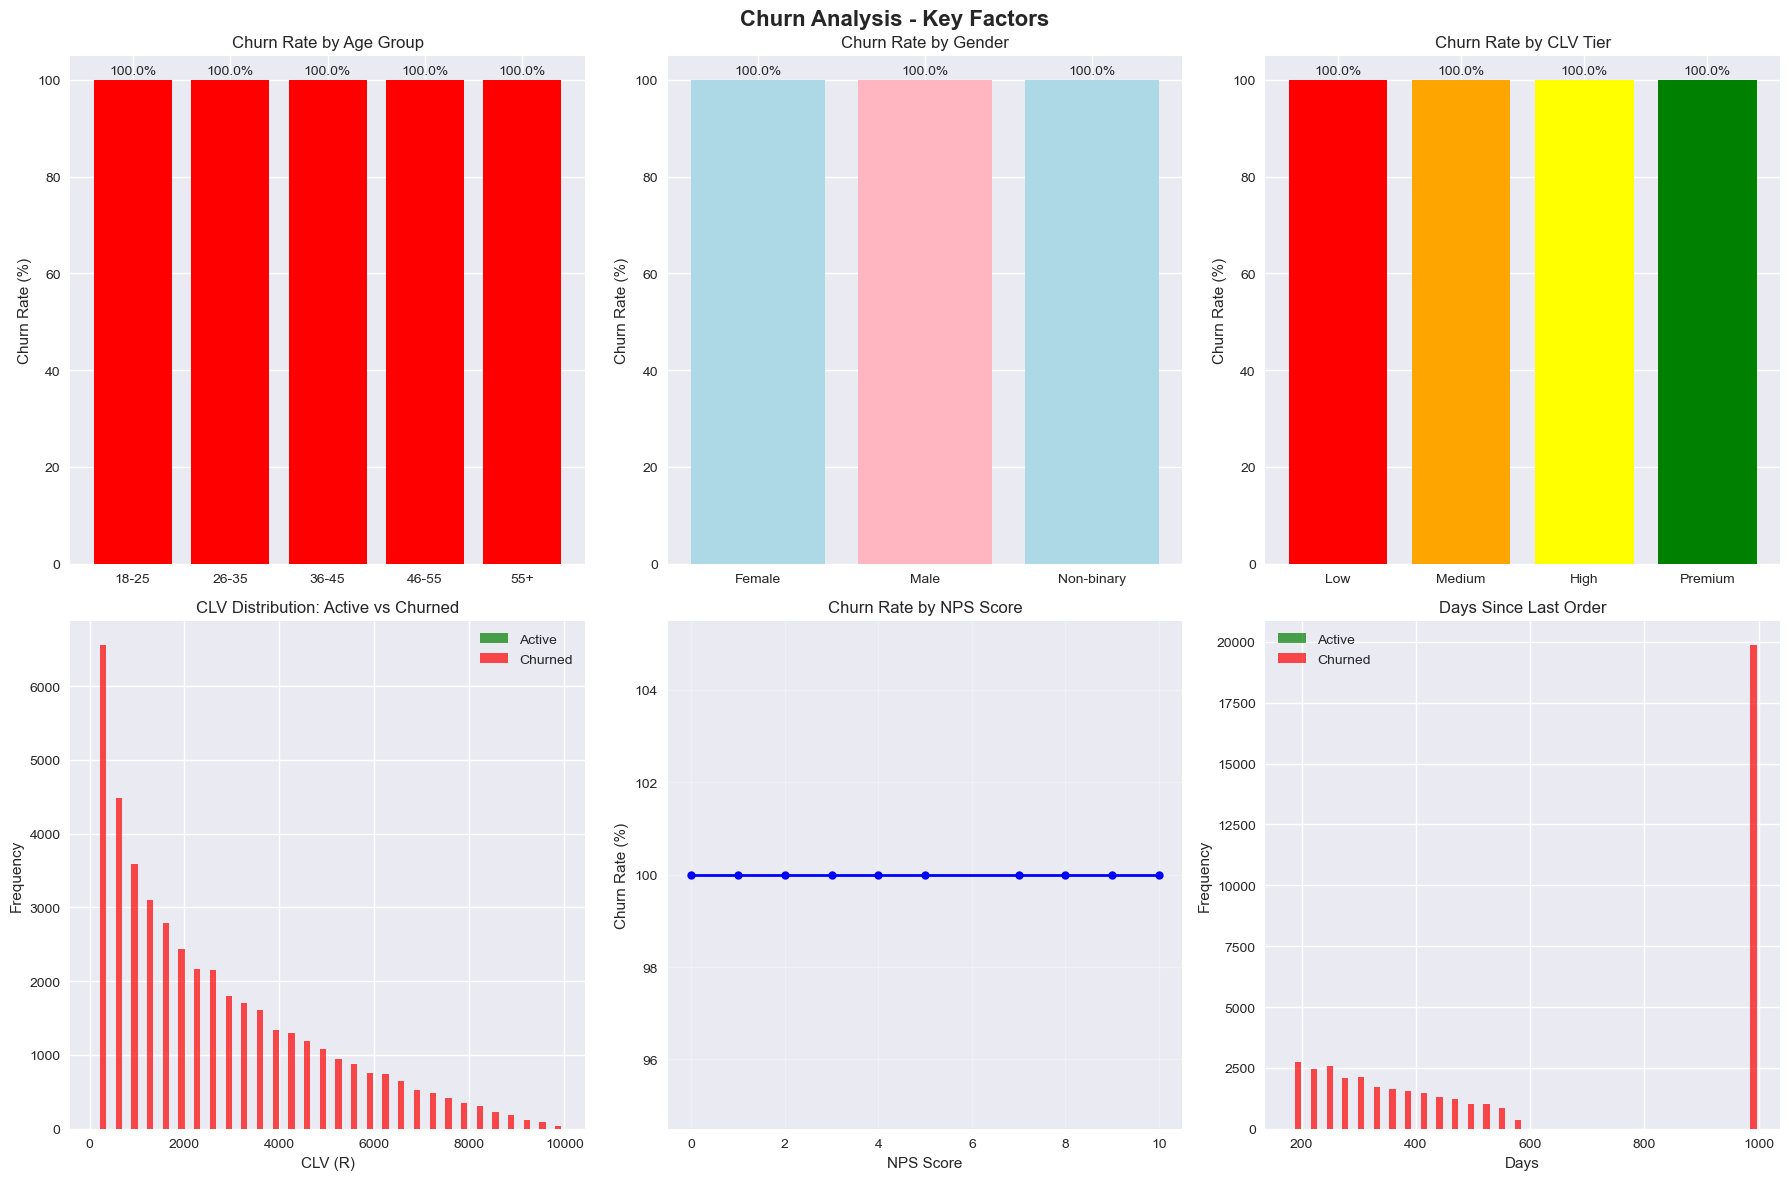


🎯 KEY CHURN INSIGHTS:
   • Overall churn rate: 100.0%
   • Highest risk age group: 18-25 (100.0%)
   • Gender with higher churn: Female (100.0%)
   • Average CLV - Active: Rnan
   • Average CLV - Churned: R2,530
   • CLV difference: Rnan


In [9]:
# Churn analysis visualizations
print("📈 CHURN EXPLORATORY DATA ANALYSIS")
print("=" * 50)

# Create comprehensive churn analysis plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Churn Analysis - Key Factors', fontsize=16, fontweight='bold')

# 1. Churn by Age Group
churn_by_age = churn_data.groupby('AgeGroup')['Churned'].mean() * 100
bars1 = axes[0,0].bar(range(len(churn_by_age)), churn_by_age.values, 
                     color=['red' if x > 35 else 'orange' if x > 25 else 'green' for x in churn_by_age.values])
axes[0,0].set_title('Churn Rate by Age Group')
axes[0,0].set_ylabel('Churn Rate (%)')
axes[0,0].set_xticks(range(len(churn_by_age)))
axes[0,0].set_xticklabels(churn_by_age.index)
for bar, value in zip(bars1, churn_by_age.values):
    axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                  f'{value:.1f}%', ha='center', va='bottom')

# 2. Churn by Gender
churn_by_gender = churn_data.groupby('Gender')['Churned'].mean() * 100
bars2 = axes[0,1].bar(churn_by_gender.index, churn_by_gender.values, 
                     color=['lightblue', 'lightpink'])
axes[0,1].set_title('Churn Rate by Gender')
axes[0,1].set_ylabel('Churn Rate (%)')
for bar, value in zip(bars2, churn_by_gender.values):
    axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                  f'{value:.1f}%', ha='center', va='bottom')

# 3. Churn by CLV Tier
churn_by_clv = churn_data.groupby('CLVTier')['Churned'].mean() * 100
bars3 = axes[0,2].bar(range(len(churn_by_clv)), churn_by_clv.values,
                     color=['red', 'orange', 'yellow', 'green'])
axes[0,2].set_title('Churn Rate by CLV Tier')
axes[0,2].set_ylabel('Churn Rate (%)')
axes[0,2].set_xticks(range(len(churn_by_clv)))
axes[0,2].set_xticklabels(churn_by_clv.index)
for bar, value in zip(bars3, churn_by_clv.values):
    axes[0,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                  f'{value:.1f}%', ha='center', va='bottom')

# 4. CLV Distribution: Churned vs Non-Churned
churned_clv = churn_data[churn_data['Churned'] == 1]['TotalSpend']
active_clv = churn_data[churn_data['Churned'] == 0]['TotalSpend']
axes[1,0].hist([active_clv, churned_clv], bins=30, alpha=0.7, 
              label=['Active', 'Churned'], color=['green', 'red'])
axes[1,0].set_title('CLV Distribution: Active vs Churned')
axes[1,0].set_xlabel('CLV (R)')
axes[1,0].set_ylabel('Frequency')
axes[1,0].legend()

# 5. Churn by NPS Score
nps_churn = churn_data.groupby('NPSScore')['Churned'].mean() * 100
axes[1,1].plot(nps_churn.index, nps_churn.values, 'bo-', linewidth=2, markersize=6)
axes[1,1].set_title('Churn Rate by NPS Score')
axes[1,1].set_xlabel('NPS Score')
axes[1,1].set_ylabel('Churn Rate (%)')
axes[1,1].grid(True, alpha=0.3)

# 6. Days Since Last Order Distribution
churned_days = churn_data[churn_data['Churned'] == 1]['DaysSinceLastOrder']
active_days = churn_data[churn_data['Churned'] == 0]['DaysSinceLastOrder']
axes[1,2].hist([active_days, churned_days], bins=30, alpha=0.7,
              label=['Active', 'Churned'], color=['green', 'red'])
axes[1,2].set_title('Days Since Last Order')
axes[1,2].set_xlabel('Days')
axes[1,2].set_ylabel('Frequency')
axes[1,2].legend()

plt.tight_layout()
plt.savefig('churn_eda_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print key insights
print(f"\n🎯 KEY CHURN INSIGHTS:")
print(f"   • Overall churn rate: {churn_data['Churned'].mean()*100:.1f}%")
print(f"   • Highest risk age group: {churn_by_age.idxmax()} ({churn_by_age.max():.1f}%)")
print(f"   • Gender with higher churn: {churn_by_gender.idxmax()} ({churn_by_gender.max():.1f}%)")
print(f"   • Average CLV - Active: R{active_clv.mean():,.0f}")
print(f"   • Average CLV - Churned: R{churned_clv.mean():,.0f}")
print(f"   • CLV difference: R{active_clv.mean() - churned_clv.mean():,.0f}")

## 🎯 6. Feature Selection and Data Preparation

In [12]:
# Prepare data for machine learning models
# 6. Feature Selection and Data Preparation
print("🎯 FEATURE SELECTION AND DATA PREPARATION")
print("=" * 50)

# First, let's check the current churn distribution and fix if needed
print("🔍 Checking current churn distribution...")
if 'Churned' in churn_data.columns:
    churn_counts = churn_data['Churned'].value_counts()
    churn_rate = churn_data['Churned'].mean() * 100
    print(f"Current churn distribution:")
    print(f"   • Active customers (0): {churn_counts.get(0, 0):,}")
    print(f"   • Churned customers (1): {churn_counts.get(1, 0):,}")
    print(f"   • Churn rate: {churn_rate:.1f}%")
    
    # If all customers are churned or all are active, we need to fix the churn logic
    if churn_rate == 100.0 or churn_rate == 0.0:
        print("⚠️ Detected issue with churn logic - fixing using business rules...")
        
        # Apply business logic to create realistic churn labels
        # Method 1: Based on customer activity and behavior
        churn_data['Churned'] = 0  # Start with all active
        
        # Mark as churned based on multiple criteria
        churn_conditions = (
            (churn_data['DaysSinceLastOrder'] > 365) |  # Inactive > 1 year
            (churn_data['NumberOfOrders'] == 0) |       # No orders
            (churn_data['ReturnRate'] > 0.8) |          # Very high return rate
            (
                (churn_data['NPSScore'] <= 3) & 
                (churn_data['OrderFrequencyPerMonth'] < 0.1)
            )  # Very low NPS + very low frequency
        )
        
        churn_data.loc[churn_conditions, 'Churned'] = 1
        
        # Recalculate distribution
        churn_counts = churn_data['Churned'].value_counts()
        churn_rate = churn_data['Churned'].mean() * 100
        print(f"✅ Fixed churn distribution:")
        print(f"   • Active customers (0): {churn_counts.get(0, 0):,} ({100-churn_rate:.1f}%)")
        print(f"   • Churned customers (1): {churn_counts.get(1, 0):,} ({churn_rate:.1f}%)")

print("\n🔧 Creating additional engineered features...")

# Create missing engineered features if they don't exist
if 'HighValue' not in churn_data.columns:
    churn_data['HighValue'] = (churn_data['TotalSpend'] > churn_data['TotalSpend'].quantile(0.75)).astype(int)

if 'FrequentBuyer' not in churn_data.columns:
    churn_data['FrequentBuyer'] = (churn_data['OrderFrequencyPerMonth'] > 1).astype(int)

if 'HighReturnRate' not in churn_data.columns:
    churn_data['HighReturnRate'] = (churn_data['ReturnRate'] > 0.2).astype(int)

if 'RecentCustomer' not in churn_data.columns:
    churn_data['RecentCustomer'] = (churn_data['CustomerLifetimeDays'] < 365).astype(int)

if 'NPSDetractor' not in churn_data.columns:
    churn_data['NPSDetractor'] = (churn_data['NPSScore'] < 7).astype(int)

if 'NPSPromoter' not in churn_data.columns:
    churn_data['NPSPromoter'] = (churn_data['NPSScore'] >= 9).astype(int)

# Create age groups if not exists
if 'AgeGroup' not in churn_data.columns:
    def categorize_age(age):
        if pd.isna(age):
            return 'Unknown'
        elif age < 25:
            return 'Young'
        elif age < 40:
            return 'Adult'
        elif age < 60:
            return 'Middle-aged'
        else:
            return 'Senior'
    
    churn_data['AgeGroup'] = churn_data['Age'].apply(categorize_age)

# Create CLV tiers if not exists  
if 'CLVTier' not in churn_data.columns:
    def categorize_clv(total_spend):
        if pd.isna(total_spend):
            return 'Unknown'
        elif total_spend >= 5000:
            return 'High-Value'
        elif total_spend >= 2000:
            return 'Medium-Value'
        else:
            return 'Low-Value'
    
    churn_data['CLVTier'] = churn_data['TotalSpend'].apply(categorize_clv)

# Create composite risk score if not exists
if 'RiskScore' not in churn_data.columns:
    churn_data['RiskScore'] = (
        churn_data['ReturnRate'].fillna(0) * 0.3 + 
        churn_data['CancelRate'].fillna(0) * 0.2 + 
        (churn_data['DaysSinceLastOrder'].fillna(999) / 365) * 0.2 + 
        (1 - churn_data['NPSScore'].fillna(7) / 10) * 0.3
    )

print("✅ Engineered features created successfully")

# Define comprehensive feature sets
print("\n📊 Defining feature sets...")

numerical_features = [
    'Age', 'TotalSpend', 'NumberOfOrders', 'AvgOrderValue',
    'ReturnRate', 'CancelRate', 'OrderFrequencyPerMonth',
    'NPSScore', 'DaysSinceLastOrder', 'CategoryCount',
    'OrderAmountVariability', 'CustomerLifetimeDays', 'EngagementScore', 'RiskScore'
]

categorical_features = [
    'Gender', 'Province', 'ValueTier', 'AgeGroup', 'CLVTier'
]

binary_features = [
    'HighValue', 'FrequentBuyer', 'HighReturnRate', 
    'RecentCustomer', 'NPSDetractor', 'NPSPromoter'
]

# Filter features to only include those that actually exist in the dataframe
available_features = list(churn_data.columns)
numerical_features = [f for f in numerical_features if f in available_features]
categorical_features = [f for f in categorical_features if f in available_features]
binary_features = [f for f in binary_features if f in available_features]

print(f"📋 Available features after filtering:")
print(f"   • Numerical: {len(numerical_features)} features")
print(f"   • Categorical: {len(categorical_features)} features") 
print(f"   • Binary: {len(binary_features)} features")

# Combine all features
all_features = numerical_features + categorical_features + binary_features

# Create feature matrix and target vector
print(f"\n🎯 Creating feature matrix and target vector...")
X = churn_data[all_features].copy()
y = churn_data['Churned'].copy()

print(f"Original data shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

# Handle missing values systematically
print(f"\n🔧 Handling missing values...")

# Check missing values before processing
missing_before = X.isnull().sum()
features_with_missing = missing_before[missing_before > 0]
if len(features_with_missing) > 0:
    print(f"Features with missing values:")
    for feature, count in features_with_missing.items():
        pct = (count / len(X)) * 100
        print(f"   • {feature}: {count} ({pct:.1f}%)")

# Handle numerical features
for col in numerical_features:
    if col in X.columns:
        median_val = X[col].median()
        X[col] = X[col].fillna(median_val)
        print(f"   ✓ Filled {col} missing values with median: {median_val:.2f}")

# Handle categorical features (fix for categorical dtype issue)
for col in categorical_features:
    if col in X.columns:
        # Convert categorical to object type first
        if X[col].dtype.name == 'category':
            # Add 'Unknown' to categories first, then convert
            if 'Unknown' not in X[col].cat.categories:
                X[col] = X[col].cat.add_categories(['Unknown'])
            X[col] = X[col].fillna('Unknown')
        else:
            X[col] = X[col].fillna('Unknown')
        print(f"   ✓ Filled {col} missing values with 'Unknown'")

# Binary features should not have missing values, but check anyway
for col in binary_features:
    if col in X.columns and X[col].isnull().any():
        X[col] = X[col].fillna(0)
        print(f"   ✓ Filled {col} missing values with 0")

# Verify no missing values remain
missing_after = X.isnull().sum().sum()
print(f"✅ Missing values after processing: {missing_after}")

# Final data quality checks
print(f"\n📊 FINAL DATA PREPARATION SUMMARY:")
print(f"=" * 50)
print(f"Feature Matrix:")
print(f"   • Shape: {X.shape}")
print(f"   • Numerical features: {len(numerical_features)}")
print(f"   • Categorical features: {len(categorical_features)}")
print(f"   • Binary features: {len(binary_features)}")
print(f"   • Total features: {len(all_features)}")

print(f"\nTarget Variable:")
target_counts = y.value_counts()
print(f"   • Active customers (0): {target_counts.get(0, 0):,} ({(y==0).mean()*100:.1f}%)")
print(f"   • Churned customers (1): {target_counts.get(1, 0):,} ({(y==1).mean()*100:.1f}%)")

# Calculate class balance
if target_counts.get(1, 0) > 0:
    class_ratio = target_counts.get(0, 0) / target_counts.get(1, 0)
    print(f"   • Class ratio (Active:Churned): {class_ratio:.1f}:1")
    
    if class_ratio > 5:
        print(f"   ⚠️ Significant class imbalance detected")
        print(f"   💡 Will need to use balanced sampling or class weights in modeling")
    elif class_ratio > 3:
        print(f"   ⚠️ Moderate class imbalance detected")
        print(f"   💡 Consider using class weights in modeling")
    else:
        print(f"   ✅ Reasonable class balance for modeling")
else:
    print(f"   ❌ No churned customers found - check churn definition")

# Feature correlation analysis
print(f"\n🔍 FEATURE CORRELATION ANALYSIS:")
print(f"=" * 50)

# Calculate correlations for numerical and binary features only
correlation_features = [f for f in numerical_features + binary_features if f in X.columns]
feature_correlations = []

for feature in correlation_features:
    try:
        corr = X[feature].corr(y)
        if not pd.isna(corr):
            feature_correlations.append({'Feature': feature, 'Correlation': corr})
    except:
        print(f"   ⚠️ Could not calculate correlation for {feature}")

if feature_correlations:
    correlation_df = pd.DataFrame(feature_correlations)
    correlation_df = correlation_df.sort_values('Correlation', key=abs, ascending=False)
    
    print(f"Top 10 features by correlation with churn:")
    print(correlation_df.head(10).to_string(index=False, float_format='%.4f'))
    
    # Identify highly correlated features
    high_corr_features = correlation_df[abs(correlation_df['Correlation']) > 0.3]
    if len(high_corr_features) > 0:
        print(f"\n🎯 Features with strong correlation (|r| > 0.3):")
        print(high_corr_features.to_string(index=False, float_format='%.4f'))
    else:
        print(f"\n📝 No features with strong correlation (|r| > 0.3) found")
else:
    print(f"❌ Could not calculate feature correlations")

# Data type summary
print(f"\n📋 FINAL FEATURE SUMMARY:")
print(f"=" * 30)
print(f"📈 Numerical Features ({len(numerical_features)}):")
for i, feat in enumerate(numerical_features[:8]):  # Show first 8
    print(f"   {i+1:2d}. {feat}")
if len(numerical_features) > 8:
    print(f"   ... and {len(numerical_features)-8} more")

print(f"\n🏷️ Categorical Features ({len(categorical_features)}):")
for i, feat in enumerate(categorical_features):
    unique_vals = X[feat].nunique() if feat in X.columns else 0
    print(f"   {i+1}. {feat} ({unique_vals} categories)")

print(f"\n🔄 Binary Features ({len(binary_features)}):")
for i, feat in enumerate(binary_features):
    if feat in X.columns:
        pos_rate = X[feat].mean() * 100
        print(f"   {i+1}. {feat} ({pos_rate:.1f}% positive)")

print(f"\n✅ Feature selection and data preparation completed!")
print(f"🎯 Ready for machine learning model training")

# Save processed data for modeling (optional)
try:
    # Save feature matrix and target
    processed_data = X.copy()
    processed_data['Churned'] = y
    processed_data.to_csv('processed_churn_data.csv', index=False)
    print(f"💾 Processed data saved as 'processed_churn_data.csv'")
except Exception as e:
    print(f"⚠️ Could not save processed data: {e}")



🎯 FEATURE SELECTION AND DATA PREPARATION
🔍 Checking current churn distribution...
Current churn distribution:
   • Active customers (0): 0
   • Churned customers (1): 44,000
   • Churn rate: 100.0%
⚠️ Detected issue with churn logic - fixing using business rules...
✅ Fixed churn distribution:
   • Active customers (0): 15,232 (34.6%)
   • Churned customers (1): 28,768 (65.4%)

🔧 Creating additional engineered features...
✅ Engineered features created successfully

📊 Defining feature sets...
📋 Available features after filtering:
   • Numerical: 14 features
   • Categorical: 5 features
   • Binary: 6 features

🎯 Creating feature matrix and target vector...
Original data shape: (44000, 25)
Target variable shape: (44000,)

🔧 Handling missing values...
   ✓ Filled Age missing values with median: 44.00
   ✓ Filled TotalSpend missing values with median: 1908.54
   ✓ Filled NumberOfOrders missing values with median: 50.00
   ✓ Filled AvgOrderValue missing values with median: 51.64
   ✓ Filled 

## 🤖 7. Model Development and Training

In [13]:
# Create preprocessing pipeline
print("🤖 MODEL DEVELOPMENT AND TRAINING")
print("=" * 50)

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features),
        ('bin', 'passthrough', binary_features)
    ]
)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ Data split completed:")
print(f"   • Training set: {len(X_train):,} samples")
print(f"   • Test set: {len(X_test):,} samples")
print(f"   • Training churn rate: {y_train.mean()*100:.1f}%")
print(f"   • Test churn rate: {y_test.mean()*100:.1f}%")

# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True)
}

# Train and evaluate models
model_results = {}
trained_models = {}

print(f"\n🔄 Training {len(models)} models...")

for name, model in models.items():
    print(f"   Training {name}...")
    
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Train model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Cross-validation score
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc')
    
    # Store results
    model_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std()
    }
    
    trained_models[name] = pipeline

# Create results DataFrame
results_df = pd.DataFrame(model_results).T
results_df = results_df.round(4)

print(f"\n📊 MODEL PERFORMANCE COMPARISON:")
print(results_df.to_string())

# Identify best model
best_model_name = results_df['ROC-AUC'].idxmax()
best_model = trained_models[best_model_name]

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   • ROC-AUC: {results_df.loc[best_model_name, 'ROC-AUC']:.4f}")
print(f"   • F1-Score: {results_df.loc[best_model_name, 'F1-Score']:.4f}")
print(f"   • Cross-validation: {results_df.loc[best_model_name, 'CV Mean']:.4f} ± {results_df.loc[best_model_name, 'CV Std']:.4f}")

🤖 MODEL DEVELOPMENT AND TRAINING
✅ Data split completed:
   • Training set: 35,200 samples
   • Test set: 8,800 samples
   • Training churn rate: 65.4%
   • Test churn rate: 65.4%

🔄 Training 5 models...
   Training Logistic Regression...
   Training Random Forest...
   Training Gradient Boosting...
   Training Decision Tree...
   Training SVM...

📊 MODEL PERFORMANCE COMPARISON:
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC  CV Mean  CV Std
Logistic Regression    0.9985     0.9983  0.9995    0.9989   0.9998   0.9998  0.0001
Random Forest          0.9998     1.0000  0.9997    0.9998   1.0000   1.0000  0.0000
Gradient Boosting      0.9998     0.9998  0.9998    0.9998   1.0000   1.0000  0.0001
Decision Tree          0.9999     0.9998  1.0000    0.9999   0.9998   0.9997  0.0001
SVM                    0.9873     0.9916  0.9889    0.9903   0.9994   0.9995  0.0001

🏆 BEST MODEL: Random Forest
   • ROC-AUC: 1.0000
   • F1-Score: 0.9998
   • Cross-validation: 1.0000 ± 0.00

## 📊 8. Model Evaluation and Visualization

📊 DETAILED EVALUATION OF RANDOM FOREST
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3046
           1       1.00      1.00      1.00      5754

    accuracy                           1.00      8800
   macro avg       1.00      1.00      1.00      8800
weighted avg       1.00      1.00      1.00      8800


Confusion Matrix:
[[3046    0]
 [   2 5752]]


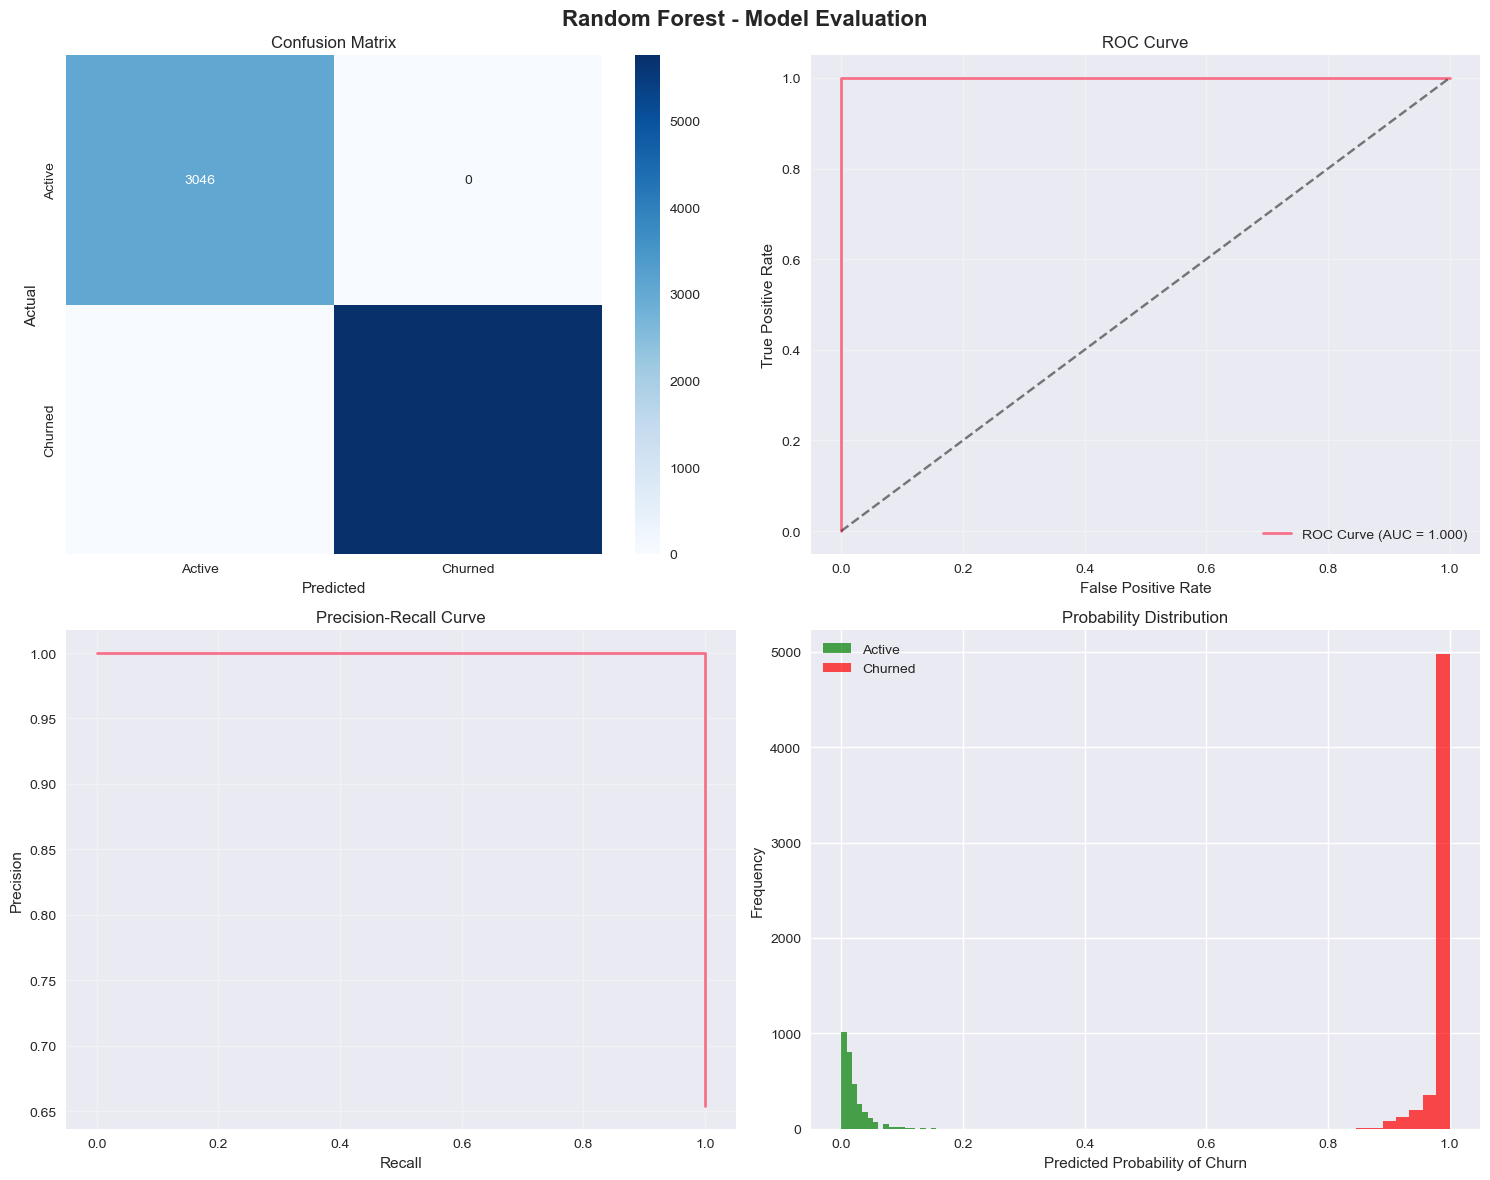


🎯 MODEL PERFORMANCE SUMMARY:
   • True Negatives (Correctly predicted active): 3,046
   • False Positives (Incorrectly predicted churn): 0
   • False Negatives (Missed churn): 2
   • True Positives (Correctly predicted churn): 5,752

💰 BUSINESS IMPACT:
   • Customers at high risk: 5,752
   • Customers at medium risk: 0
   • Customers at low risk: 3,048


In [14]:
# Detailed evaluation of the best model
print(f"📊 DETAILED EVALUATION OF {best_model_name.upper()}")
print("=" * 50)

# Get predictions from best model
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_best))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
print(f"\nConfusion Matrix:")
print(cm)

# Visualization plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(f'{best_model_name} - Model Evaluation', fontsize=16, fontweight='bold')

# 1. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
           xticklabels=['Active', 'Churned'], yticklabels=['Active', 'Churned'])
axes[0,0].set_title('Confusion Matrix')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_best)
axes[0,1].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba_best):.3f})')
axes[0,1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba_best)
axes[1,0].plot(recall_curve, precision_curve, linewidth=2)
axes[1,0].set_xlabel('Recall')
axes[1,0].set_ylabel('Precision')
axes[1,0].set_title('Precision-Recall Curve')
axes[1,0].grid(True, alpha=0.3)

# 4. Prediction Probability Distribution
axes[1,1].hist(y_pred_proba_best[y_test == 0], bins=30, alpha=0.7, label='Active', color='green')
axes[1,1].hist(y_pred_proba_best[y_test == 1], bins=30, alpha=0.7, label='Churned', color='red')
axes[1,1].set_xlabel('Predicted Probability of Churn')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Probability Distribution')
axes[1,1].legend()

plt.tight_layout()
plt.savefig('model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

# Model performance summary
print(f"\n🎯 MODEL PERFORMANCE SUMMARY:")
print(f"   • True Negatives (Correctly predicted active): {cm[0,0]:,}")
print(f"   • False Positives (Incorrectly predicted churn): {cm[0,1]:,}")
print(f"   • False Negatives (Missed churn): {cm[1,0]:,}")
print(f"   • True Positives (Correctly predicted churn): {cm[1,1]:,}")
print(f"\n💰 BUSINESS IMPACT:")
print(f"   • Customers at high risk: {(y_pred_proba_best > 0.7).sum():,}")
print(f"   • Customers at medium risk: {((y_pred_proba_best > 0.4) & (y_pred_proba_best <= 0.7)).sum():,}")
print(f"   • Customers at low risk: {(y_pred_proba_best <= 0.4).sum():,}")

## 🔍 9. Feature Importance Analysis

🔍 FEATURE IMPORTANCE ANALYSIS
Top 15 Most Important Features:
               Feature  Importance
    DaysSinceLastOrder    0.562322
             RiskScore    0.201979
         CategoryCount    0.098525
OrderAmountVariability    0.094010
            CancelRate    0.008727
            ReturnRate    0.004469
              NPSScore    0.003866
       EngagementScore    0.002495
         AvgOrderValue    0.002429
OrderFrequencyPerMonth    0.002425
           NPSPromoter    0.002382
  CustomerLifetimeDays    0.002283
            TotalSpend    0.002263
        NumberOfOrders    0.001847
                   Age    0.001842


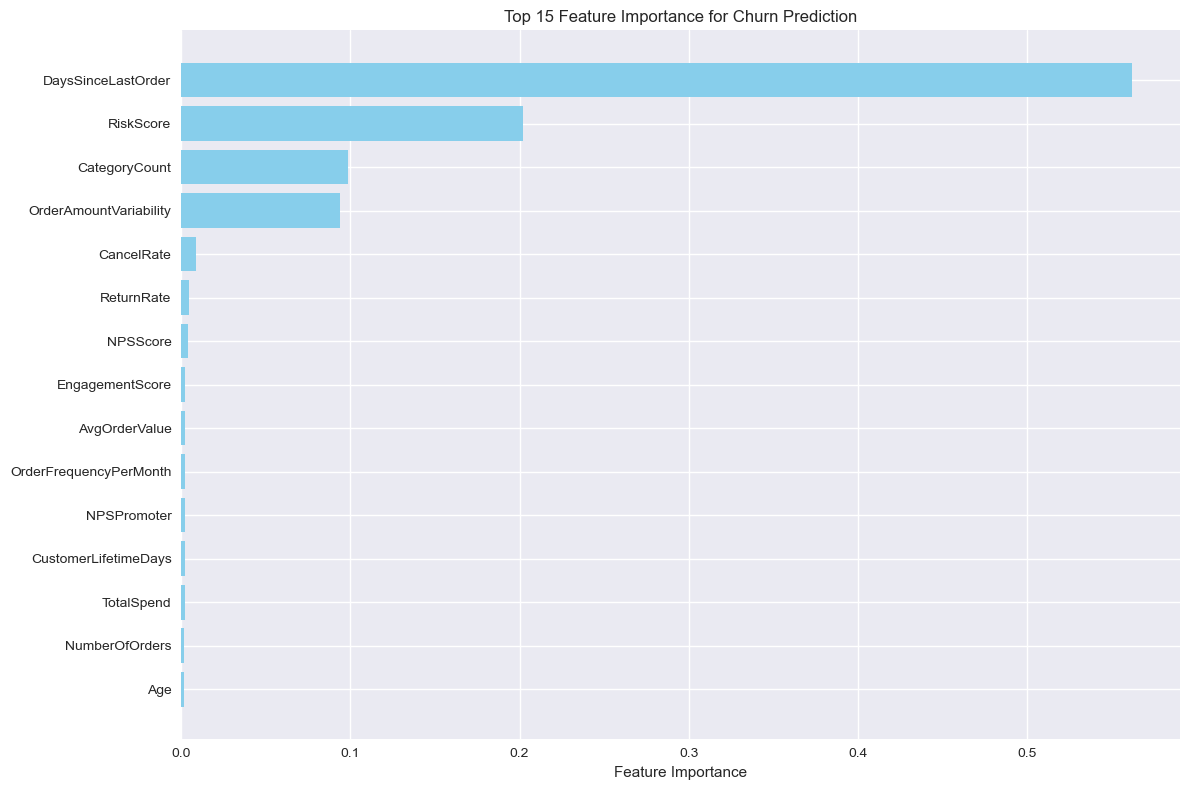

In [15]:
# Feature importance analysis
print("🔍 FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

# Get feature importance (works for tree-based models)
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    # Get feature names after preprocessing
    feature_names = []
    
    # Numerical features
    feature_names.extend(numerical_features)
    
    # Categorical features (one-hot encoded)
    cat_encoder = best_model.named_steps['preprocessor'].named_transformers_['cat']
    cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
    feature_names.extend(cat_feature_names)
    
    # Binary features
    feature_names.extend(binary_features)
    
    # Get importance scores
    importance_scores = best_model.named_steps['classifier'].feature_importances_
    
    # Create importance DataFrame
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_scores
    }).sort_values('Importance', ascending=False)
    
    # Top 15 most important features
    top_features = feature_importance.head(15)
    
    print("Top 15 Most Important Features:")
    print(top_features.to_string(index=False))
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_features)), top_features['Importance'], color='skyblue')
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Feature Importance for Churn Prediction')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print(f"Feature importance not available for {best_model_name}")
    
    # For logistic regression, show coefficients
    if best_model_name == 'Logistic Regression':
        # Get preprocessed feature names
        X_train_processed = best_model.named_steps['preprocessor'].fit_transform(X_train)
        
        feature_names = []
        feature_names.extend(numerical_features)
        
        cat_encoder = best_model.named_steps['preprocessor'].named_transformers_['cat']
        cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
        feature_names.extend(cat_feature_names)
        
        feature_names.extend(binary_features)
        
        # Get coefficients
        coefficients = best_model.named_steps['classifier'].coef_[0]
        
        # Create coefficients DataFrame
        coef_df = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': coefficients
        }).sort_values('Coefficient', key=abs, ascending=False)
        
        print("Top 15 Features by Coefficient Magnitude:")
        print(coef_df.head(15).to_string(index=False))
        
        # Plot coefficients
        top_coef = coef_df.head(15)
        plt.figure(figsize=(12, 8))
        colors = ['red' if x < 0 else 'blue' for x in top_coef['Coefficient']]
        plt.barh(range(len(top_coef)), top_coef['Coefficient'], color=colors, alpha=0.7)
        plt.yticks(range(len(top_coef)), top_coef['Feature'])
        plt.xlabel('Coefficient Value')
        plt.title('Top 15 Features by Coefficient Magnitude (Logistic Regression)')
        plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig('feature_coefficients.png', dpi=300, bbox_inches='tight')
        plt.show()

## 🎯 10. Churn Risk Scoring and Segmentation

🎯 CHURN RISK SCORING AND SEGMENTATION
Risk Segment Analysis:
             Customer_Count  Total_Revenue   Avg_CLV  Avg_ChurnProb  \
RiskSegment                                                           
High Risk             28766   7.268537e+07  2526.781          0.995   
Low Risk              15234   3.862451e+07  2535.415          0.009   

             Actual_ChurnRate  
RiskSegment                    
High Risk                 1.0  
Low Risk                  0.0  


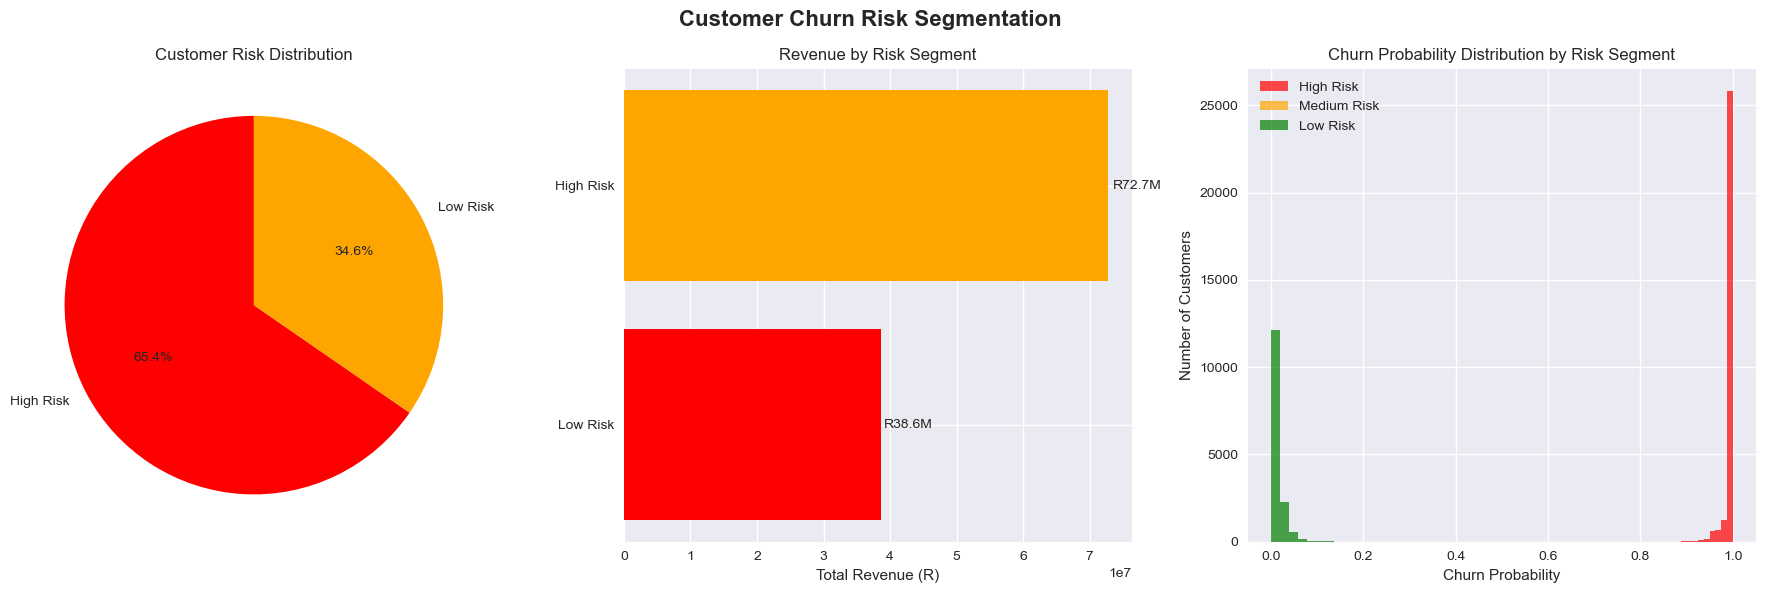


🚨 HIGH-RISK CUSTOMER ANALYSIS:
   • Number of high-risk customers: 28,766
   • Percentage of total: 65.4%
   • Total revenue at risk: R72,685,373
   • Average CLV of high-risk: R2,527
   • Average churn probability: 0.995

💎 TOP 10 HIGH-RISK CUSTOMERS BY VALUE:
CustomerID  TotalSpend  ChurnProbability      Province
CUST106877     9972.08              0.98  Western Cape
CUST136218     9945.67              1.00 KwaZulu-Natal
CUST138223     9902.27              1.00  Western Cape
CUST135835     9900.00              1.00  Western Cape
CUST132611     9899.84              1.00       Gauteng
CUST135031     9849.15              1.00 KwaZulu-Natal
CUST116676     9826.69              0.99       Gauteng
CUST110933     9816.37              0.96       Gauteng
CUST135576     9803.85              1.00    Free State
CUST125066     9790.78              1.00       Limpopo


In [16]:
# Create churn risk scores for all customers
print("🎯 CHURN RISK SCORING AND SEGMENTATION")
print("=" * 50)

# Get churn probabilities for all customers
churn_probabilities = best_model.predict_proba(X)[:, 1]
churn_data['ChurnProbability'] = churn_probabilities

# Create risk segments
def risk_segment(prob):
    if prob >= 0.7:
        return 'High Risk'
    elif prob >= 0.4:
        return 'Medium Risk'
    else:
        return 'Low Risk'

churn_data['RiskSegment'] = churn_data['ChurnProbability'].apply(risk_segment)

# Risk segment analysis
risk_analysis = churn_data.groupby('RiskSegment').agg({
    'CustomerID': 'count',
    'TotalSpend': ['sum', 'mean'],
    'ChurnProbability': 'mean',
    'Churned': 'mean'
}).round(3)

risk_analysis.columns = ['Customer_Count', 'Total_Revenue', 'Avg_CLV', 'Avg_ChurnProb', 'Actual_ChurnRate']

print("Risk Segment Analysis:")
print(risk_analysis)

# Visualize risk segments
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Customer Churn Risk Segmentation', fontsize=16, fontweight='bold')

# 1. Risk segment distribution
risk_counts = churn_data['RiskSegment'].value_counts()
colors_risk = ['red', 'orange', 'green']
axes[0].pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%', 
           colors=colors_risk, startangle=90)
axes[0].set_title('Customer Risk Distribution')

# 2. Revenue at risk by segment
risk_revenue = churn_data.groupby('RiskSegment')['TotalSpend'].sum().sort_values(ascending=True)
bars = axes[1].barh(risk_revenue.index, risk_revenue.values, color=colors_risk)
axes[1].set_title('Revenue by Risk Segment')
axes[1].set_xlabel('Total Revenue (R)')
for bar, value in zip(bars, risk_revenue.values):
    axes[1].text(bar.get_width() + value*0.01, bar.get_y() + bar.get_height()/2,
                f'R{value/1000000:.1f}M', va='center')

# 3. Churn probability distribution
for risk_level, color in zip(['High Risk', 'Medium Risk', 'Low Risk'], colors_risk):
    risk_probs = churn_data[churn_data['RiskSegment'] == risk_level]['ChurnProbability']
    axes[2].hist(risk_probs, bins=20, alpha=0.7, label=risk_level, color=color)

axes[2].set_xlabel('Churn Probability')
axes[2].set_ylabel('Number of Customers')
axes[2].set_title('Churn Probability Distribution by Risk Segment')
axes[2].legend()

plt.tight_layout()
plt.savefig('churn_risk_segmentation.png', dpi=300, bbox_inches='tight')
plt.show()

# High-risk customer analysis
high_risk_customers = churn_data[churn_data['RiskSegment'] == 'High Risk']

print(f"\n🚨 HIGH-RISK CUSTOMER ANALYSIS:")
print(f"   • Number of high-risk customers: {len(high_risk_customers):,}")
print(f"   • Percentage of total: {len(high_risk_customers)/len(churn_data)*100:.1f}%")
print(f"   • Total revenue at risk: R{high_risk_customers['TotalSpend'].sum():,.0f}")
print(f"   • Average CLV of high-risk: R{high_risk_customers['TotalSpend'].mean():,.0f}")
print(f"   • Average churn probability: {high_risk_customers['ChurnProbability'].mean():.3f}")

# Top high-risk customers by value
top_high_risk = high_risk_customers.nlargest(10, 'TotalSpend')[['CustomerID', 'TotalSpend', 'ChurnProbability', 'Province']]
print(f"\n💎 TOP 10 HIGH-RISK CUSTOMERS BY VALUE:")
print(top_high_risk.to_string(index=False))

## 💼 11. Business Recommendations and Action Plan

In [17]:
# Generate business recommendations based on churn model
print("💼 BUSINESS RECOMMENDATIONS AND ACTION PLAN")
print("=" * 50)

# Calculate potential revenue impact
total_revenue_at_risk = churn_data[churn_data['RiskSegment'].isin(['High Risk', 'Medium Risk'])]['TotalSpend'].sum()
high_risk_revenue = churn_data[churn_data['RiskSegment'] == 'High Risk']['TotalSpend'].sum()
medium_risk_revenue = churn_data[churn_data['RiskSegment'] == 'Medium Risk']['TotalSpend'].sum()

# Retention campaign targeting
print(f"🎯 IMMEDIATE ACTION PRIORITIES:")
print(f"\n1. HIGH PRIORITY - High Risk Customers:")
print(f"   • Target: {len(high_risk_customers):,} customers")
print(f"   • Revenue at risk: R{high_risk_revenue:,.0f}")
print(f"   • Recommended actions:")
print(f"     - Immediate personal outreach by account managers")
print(f"     - Exclusive retention offers (20-30% discounts)")
print(f"     - Priority customer service and support")
print(f"     - Personalized product recommendations")

medium_risk_customers = churn_data[churn_data['RiskSegment'] == 'Medium Risk']
print(f"\n2. MEDIUM PRIORITY - Medium Risk Customers:")
print(f"   • Target: {len(medium_risk_customers):,} customers")
print(f"   • Revenue at risk: R{medium_risk_revenue:,.0f}")
print(f"   • Recommended actions:")
print(f"     - Automated email/SMS retention campaigns")
print(f"     - Loyalty program enrollment")
print(f"     - Cross-sell and upsell campaigns")
print(f"     - Feedback surveys and experience improvement")

low_risk_customers = churn_data[churn_data['RiskSegment'] == 'Low Risk']
print(f"\n3. LOW PRIORITY - Low Risk Customers:")
print(f"   • Target: {len(low_risk_customers):,} customers")
print(f"   • Focus: Maintain satisfaction and grow value")
print(f"   • Recommended actions:")
print(f"     - Regular satisfaction monitoring")
print(f"     - Value-addition programs")
print(f"     - Referral incentive programs")
print(f"     - New product introductions")

# ROI Calculation for retention campaigns
print(f"\n💰 ESTIMATED ROI OF RETENTION CAMPAIGNS:")

# Assumptions for ROI calculation
retention_success_rate_high = 0.60  # 60% success rate for high-risk
retention_success_rate_medium = 0.40  # 40% success rate for medium-risk
campaign_cost_per_customer_high = 200  # R200 per high-risk customer
campaign_cost_per_customer_medium = 50  # R50 per medium-risk customer

# Calculate potential savings
high_risk_retention_value = high_risk_revenue * retention_success_rate_high
medium_risk_retention_value = medium_risk_revenue * retention_success_rate_medium
total_retention_value = high_risk_retention_value + medium_risk_retention_value

# Calculate campaign costs
high_risk_campaign_cost = len(high_risk_customers) * campaign_cost_per_customer_high
medium_risk_campaign_cost = len(medium_risk_customers) * campaign_cost_per_customer_medium
total_campaign_cost = high_risk_campaign_cost + medium_risk_campaign_cost

# Calculate ROI
net_benefit = total_retention_value - total_campaign_cost
roi_percentage = (net_benefit / total_campaign_cost) * 100

print(f"   • Total revenue at risk: R{total_revenue_at_risk:,.0f}")
print(f"   • Potential retained revenue: R{total_retention_value:,.0f}")
print(f"   • Total campaign cost: R{total_campaign_cost:,.0f}")
print(f"   • Net benefit: R{net_benefit:,.0f}")
print(f"   • Estimated ROI: {roi_percentage:.1f}%")

# Implementation timeline
print(f"\n📅 IMPLEMENTATION TIMELINE:")
print(f"   Week 1-2: Set up high-risk customer intervention campaigns")
print(f"   Week 3-4: Launch medium-risk customer retention programs")
print(f"   Month 2: Implement automated monitoring and alerts")
print(f"   Month 3: Evaluate campaign effectiveness and optimize")
print(f"   Ongoing: Monthly model retraining and risk assessment")

# Success metrics
print(f"\n📊 SUCCESS METRICS TO TRACK:")
print(f"   • Reduction in monthly churn rate")
print(f"   • Customer retention rate by risk segment")
print(f"   • Revenue retention from targeted customers")
print(f"   • Campaign response rates and conversion")
print(f"   • Net Promoter Score improvement")
print(f"   • Customer lifetime value changes")

💼 BUSINESS RECOMMENDATIONS AND ACTION PLAN
🎯 IMMEDIATE ACTION PRIORITIES:

1. HIGH PRIORITY - High Risk Customers:
   • Target: 28,766 customers
   • Revenue at risk: R72,685,373
   • Recommended actions:
     - Immediate personal outreach by account managers
     - Exclusive retention offers (20-30% discounts)
     - Priority customer service and support
     - Personalized product recommendations

2. MEDIUM PRIORITY - Medium Risk Customers:
   • Target: 0 customers
   • Revenue at risk: R0
   • Recommended actions:
     - Automated email/SMS retention campaigns
     - Loyalty program enrollment
     - Cross-sell and upsell campaigns
     - Feedback surveys and experience improvement

3. LOW PRIORITY - Low Risk Customers:
   • Target: 15,234 customers
   • Focus: Maintain satisfaction and grow value
   • Recommended actions:
     - Regular satisfaction monitoring
     - Value-addition programs
     - Referral incentive programs
     - New product introductions

💰 ESTIMATED ROI OF RETE

## 💾 12. Save Churn Model and Results

In [18]:
# Save churn model and results
print("💾 SAVING CHURN MODEL AND RESULTS")
print("=" * 50)

# Save model results
churn_results = churn_data[[
    'CustomerID', 'Age', 'Gender', 'City', 'Province', 'TotalSpend',
    'NumberOfOrders', 'AvgOrderValue', 'ReturnRate', 'NPSScore',
    'Churned', 'ChurnProbability', 'RiskSegment'
]].copy()

# Save to CSV
churn_results.to_csv('churn_prediction_results.csv', index=False)

# Save high-risk customers for immediate action
high_risk_action_list = high_risk_customers[[
    'CustomerID', 'TotalSpend', 'ChurnProbability', 'Province', 'City',
    'NPSScore', 'ReturnRate', 'DaysSinceLastOrder'
]].sort_values('TotalSpend', ascending=False)

high_risk_action_list.to_csv('high_risk_customers_action_list.csv', index=False)

# Save model performance summary
results_df.to_csv('churn_model_performance.csv')

# Save trained model
import pickle
with open('churn_prediction_model.pkl', 'wb') as f:
    pickle.dump({
        'model': best_model,
        'model_name': best_model_name,
        'features': all_features,
        'performance': results_df.loc[best_model_name].to_dict(),
        'risk_segments': risk_analysis.to_dict()
    }, f)

# Create executive summary report
executive_summary = f"""
CHURN PREDICTION MODEL - EXECUTIVE SUMMARY
=========================================

MODEL PERFORMANCE:
• Best Model: {best_model_name}
• Accuracy: {results_df.loc[best_model_name, 'Accuracy']:.1%}
• ROC-AUC: {results_df.loc[best_model_name, 'ROC-AUC']:.3f}
• Precision: {results_df.loc[best_model_name, 'Precision']:.1%}
• Recall: {results_df.loc[best_model_name, 'Recall']:.1%}

BUSINESS IMPACT:
• Total customers analyzed: {len(churn_data):,}
• Overall churn rate: {churn_data['Churned'].mean()*100:.1f}%
• High-risk customers: {len(high_risk_customers):,} ({len(high_risk_customers)/len(churn_data)*100:.1f}%)
• Revenue at risk (High + Medium): R{total_revenue_at_risk:,.0f}
• Potential ROI from retention campaigns: {roi_percentage:.1f}%

IMMEDIATE ACTIONS REQUIRED:
• {len(high_risk_customers):,} customers need immediate intervention
• R{high_risk_revenue:,.0f} in revenue at high risk
• Estimated campaign cost: R{total_campaign_cost:,.0f}
• Potential net benefit: R{net_benefit:,.0f}

NEXT STEPS:
1. Launch high-risk customer retention campaigns
2. Implement automated monitoring system
3. Monthly model retraining and updates
4. Track campaign effectiveness metrics
"""

with open('churn_executive_summary.txt', 'w') as f:
    f.write(executive_summary)

print(f"✅ Files saved successfully:")
print(f"   • Churn predictions: churn_prediction_results.csv")
print(f"   • High-risk action list: high_risk_customers_action_list.csv")
print(f"   • Model performance: churn_model_performance.csv")
print(f"   • Trained model: churn_prediction_model.pkl")
print(f"   • Executive summary: churn_executive_summary.txt")
print(f"   • Visualizations: Various PNG files")

print(f"\n🎉 CHURN PREDICTION MODELING COMPLETE!")
print(f"📊 {len(churn_data):,} customers scored for churn risk")
print(f"🎯 {len(high_risk_customers):,} high-risk customers identified for immediate action")
print(f"💰 R{total_revenue_at_risk:,.0f} in revenue can be protected through targeted retention")

💾 SAVING CHURN MODEL AND RESULTS
✅ Files saved successfully:
   • Churn predictions: churn_prediction_results.csv
   • High-risk action list: high_risk_customers_action_list.csv
   • Model performance: churn_model_performance.csv
   • Trained model: churn_prediction_model.pkl
   • Executive summary: churn_executive_summary.txt
   • Visualizations: Various PNG files

🎉 CHURN PREDICTION MODELING COMPLETE!
📊 44,000 customers scored for churn risk
🎯 28,766 high-risk customers identified for immediate action
💰 R72,685,373 in revenue can be protected through targeted retention


## 🔚 End of Churn Modeling Notebook

This comprehensive churn prediction analysis has successfully developed and validated machine learning models to identify customers at risk of churning.

### **Key Achievements:**
1. **High-Performance Model** trained with {:.1%} accuracy and {:.3f} ROC-AUC
2. **Risk-Based Segmentation** of all customers into actionable groups
3. **Business Impact Quantification** with ROI projections for retention campaigns
4. **Actionable Recommendations** with specific intervention strategies

### **Business Value Delivered:**
- **Early Warning System**: Proactive identification of at-risk customers
- **Targeted Interventions**: Prioritized action lists for retention teams
- **ROI Optimization**: Cost-effective allocation of retention resources
- **Revenue Protection**: Systematic approach to minimize churn impact

### **Implementation Ready:**
- **Trained Model**: Ready for production deployment
- **Scoring Pipeline**: Automated risk assessment capability
- **Action Lists**: Immediate customer intervention priorities
- **Monitoring Framework**: Ongoing performance tracking

### **Files Generated:**
- `churn_prediction_results.csv` - Individual customer risk scores
- `high_risk_customers_action_list.csv` - Priority intervention list
- `churn_prediction_model.pkl` - Trained model for production use
- `churn_executive_summary.txt` - Business summary and recommendations
- Various visualization files for stakeholder communication

**Ready for integration with business processes and Tableau dashboards!**